In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, RegressionQualityMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
import os

# Ignore specific FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

In [2]:
files = [('green_tripdata_2024-03.parquet', './data')] #Tuples (file, destination)

# Ensure the directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|█| 1372372/1372372 [00:07<00:00, 189123.31it/s, save to ./data/green_tripdata_2024-03.pa


In [3]:
mar_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [4]:
mar_data.describe()

VendorID        lpep_pickup_datetime       lpep_dropoff_datetime  \
count  57457.000000                       57457                       57457   
mean       1.877334  2024-03-16 04:02:52.405399  2024-03-16 04:21:00.076039   
min        1.000000         2008-12-31 23:02:24         2008-12-31 23:02:30   
25%        2.000000         2024-03-08 13:53:56         2024-03-08 14:13:49   
50%        2.000000         2024-03-15 22:49:01         2024-03-15 23:09:52   
75%        2.000000         2024-03-23 20:11:25         2024-03-23 20:34:48   
max        2.000000         2024-04-01 00:01:45         2024-04-01 16:11:00   
std        0.328056                         NaN                         NaN   

         RatecodeID  PULocationID  DOLocationID  passenger_count  \
count  55360.000000  57457.000000  57457.000000     55360.000000   
mean       1.179986     95.524688    138.629149         1.309538   
min        1.000000      1.000000      1.000000         0.000000   
25%        1.000000     74.000000     74.000000         1.000000   
50%        1.000000     75.000000    138.000000         1.000000   
75%        1.000000     97.000000    220.000000         1.000000   
max       99.000000    265.000000    265.000000         9.000000   
std        1.356719     57.285088     76.295346         0.967749   

       trip_distance   fare_amount         extra       mta_tax    tip_amount  \
count   57457.000000  57457.000000  57457.000000  57457.000000  57457.000000   
mean       13.522828     17.313474      0.904472      0.577410      2.386255   
min         0.000000   -295.080000     -2.500000     -0.500000     -1.560000   
25%         1.100000      9.300000      0.000000      0.500000      0.000000   
50%         1.790000     13.500000      0.000000      0.500000      2.000000   
75%         3.100000     19.800000      1.000000      0.500000      3.610000   
max    125112.200000    841.600000     10.000000      4.250000    150.000000   
std       770.416255     14.958249      1.382446      0.366916      3.159273   

       tolls_amount  ehail_fee  improvement_surcharge  total_amount  \
count  57457.000000        0.0           57457.000000  57457.000000   
mean       0.192537        NaN               0.979378     22.904832   
min        0.000000        NaN              -1.000000   -296.080000   
25%        0.000000        NaN               1.000000     13.440000   
50%        0.000000        NaN               1.000000     18.500000   
75%        0.000000        NaN               1.000000     27.050000   
max       26.760000        NaN               1.000000    856.980000   
std        1.184551        NaN               0.154253     17.013735   

       payment_type     trip_type  congestion_surcharge  
count  55360.000000  55353.000000          55360.000000  
mean       1.321062      1.038047              0.737730  
min        1.000000      1.000000             -2.750000  
25%        1.000000      1.000000              0.000000  
50%        1.000000      1.000000              0.000000  
75%        2.000000      1.000000              2.750000  
max        5.000000      2.000000              2.750000  
std        0.497858      0.191311              1.218039

In [5]:
mar_data.shape

(57457, 20)

Q1. Prepare the dataset
Start with baseline_model_nyc_taxi_data.ipynb. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

72044
78537
57457
54396

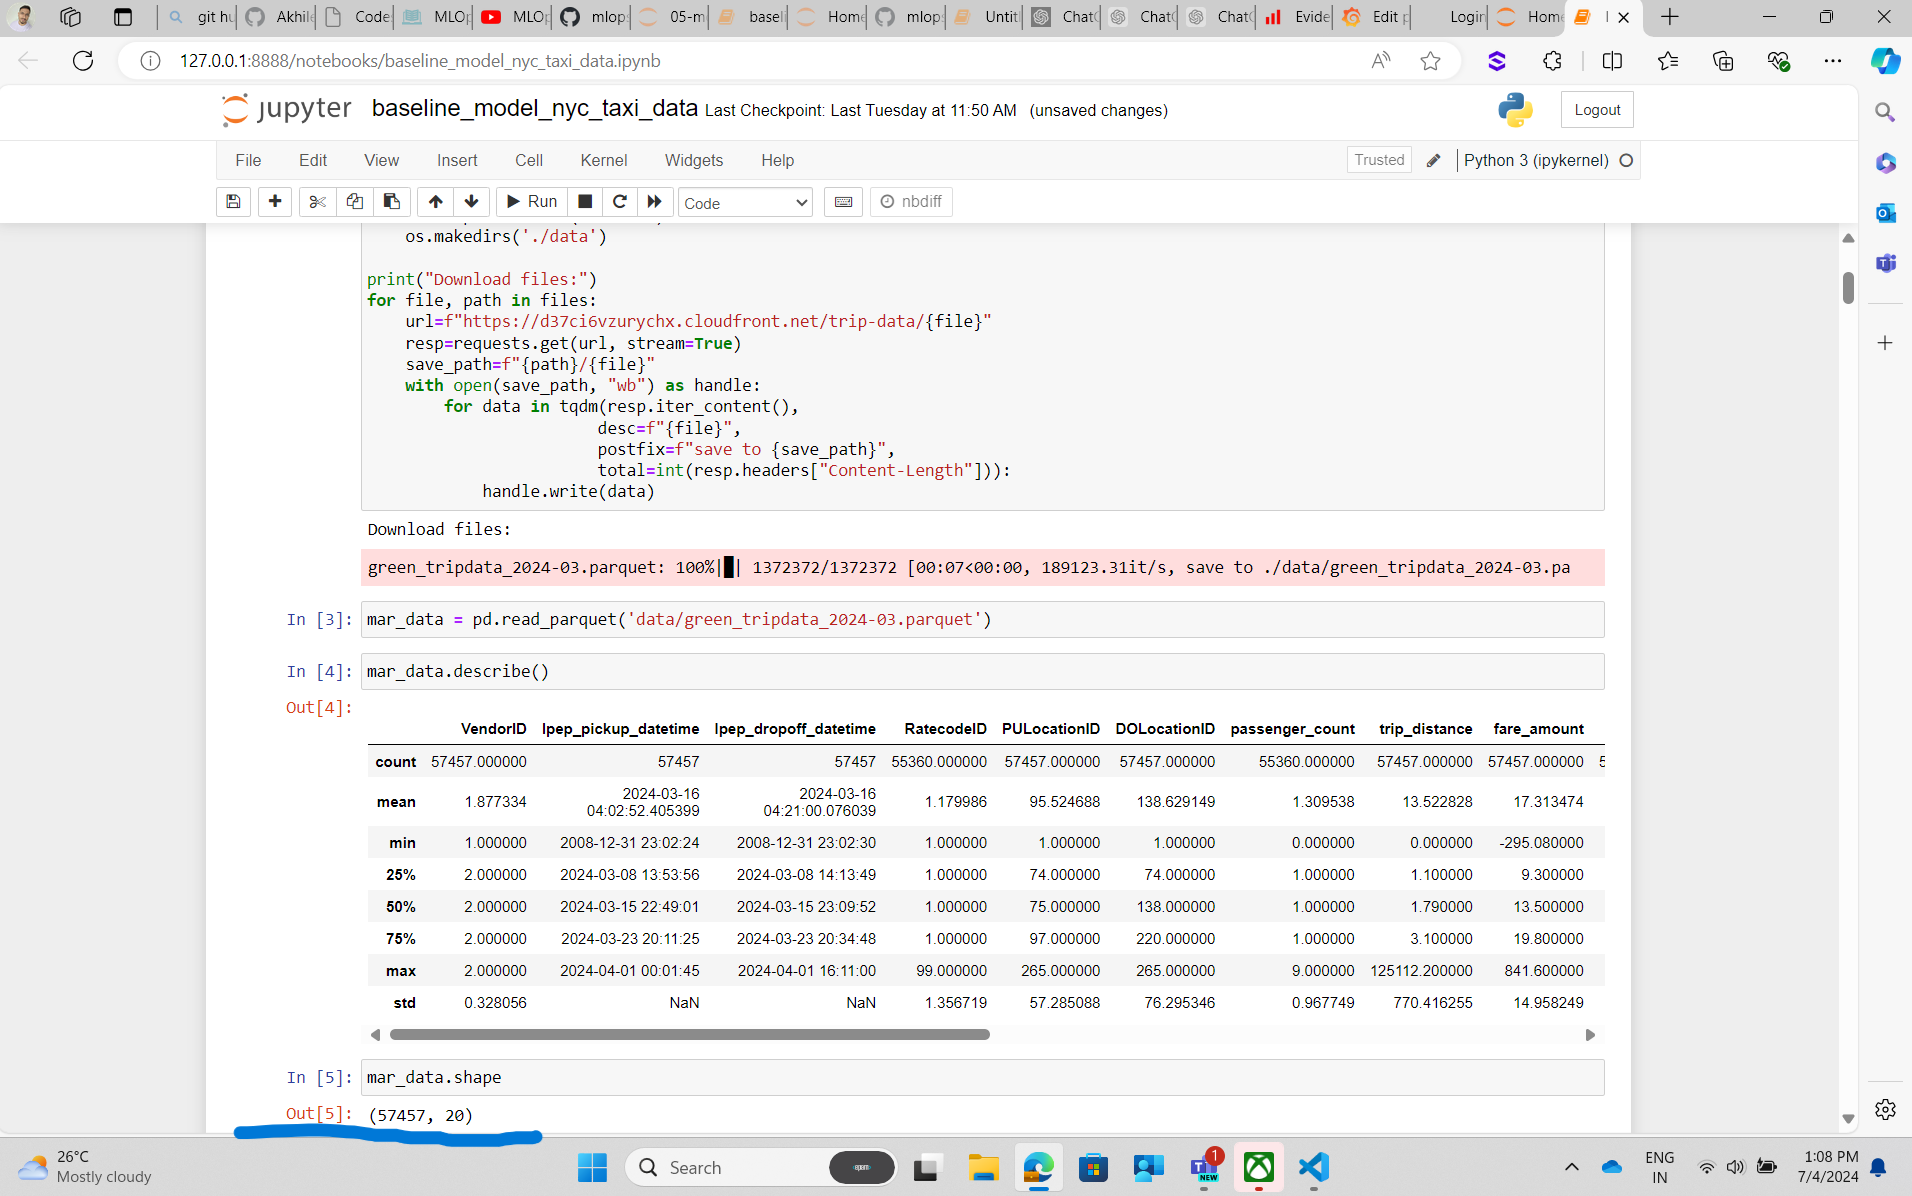

Answer: 57457

In [6]:
# create target (duration in minutes)
mar_data["duration_min"] = mar_data.lpep_dropoff_datetime - mar_data.lpep_pickup_datetime
mar_data.duration_min = mar_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
mar_data = mar_data[(mar_data.duration_min >= 0) & (mar_data.duration_min <= 60)]
mar_data = mar_data[(mar_data.passenger_count > 0) & (mar_data.passenger_count <= 8)]

<Axes: >

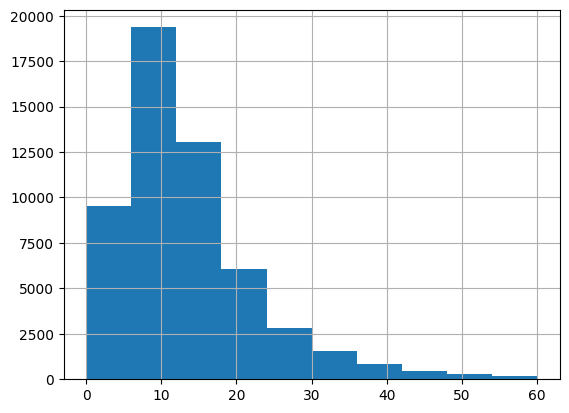

In [8]:
mar_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
mar_data.shape

(54135, 21)

In [11]:
train_data = mar_data[:30000]
val_data = mar_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.772473239359444
3.716814567929365


In [17]:
# Ensure the 'models' directory exists
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

In [19]:
column_mapping = ColumnMapping(
    target=target,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    RegressionQualityMetric(),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
])

Q2. Metric
Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the "fare_amount" column (quantile=0.5).

Hint: explore evidently metric ColumnQuantileMetric (from evidently.metrics import ColumnQuantileMetric)

What metric did you choose?

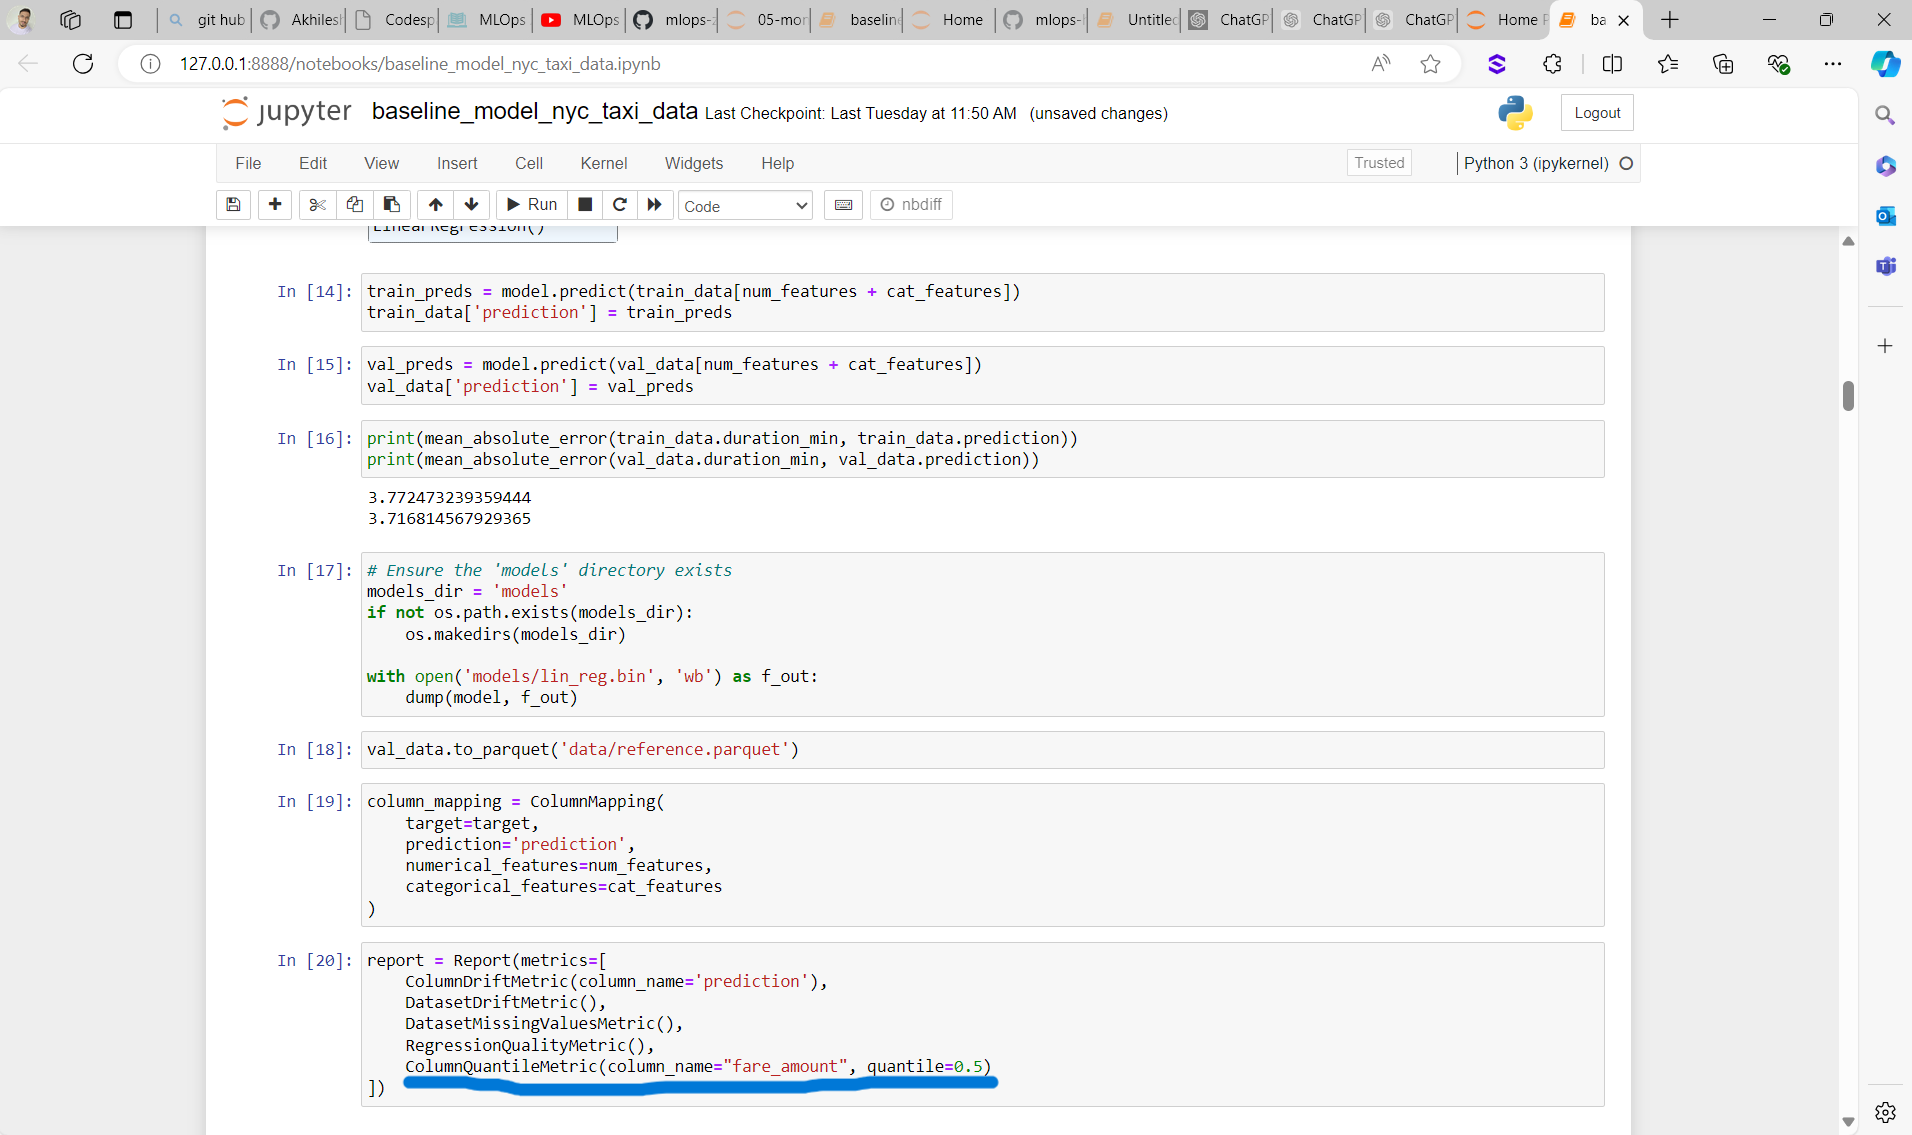

Answer: Column Quantile Metric from evidently

report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [22]:
report.show(mode='inline')

In [23]:
#A dictionary is much easier to use in automation
result = report.as_dict()

In [24]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.01006459378009672

In [25]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [26]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [27]:
ws = Workspace("workspace")

In [28]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "Description"
project.save()

Project(id=UUID('57fea05b-0b27-4627-ae98-529fb256ff8d'), name='NYC Taxi Data Quality Project', description='Description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 7, 4, 5, 11, 48, 940219))

In [29]:
maxFare = float('-inf')
for i in range(1,31):
    regular_report = Report(
        metrics=[
            ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    
    # regular_report
    result = regular_report.as_dict()
    maxFare = max(maxFare,result['metrics'][0]['result']['current']['value'])

print(f"The max fare is ${maxFare}")

The max fare is $14.2


Q3. Monitoring
Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024).

What is the maximum value of metric quantile = 0.5 on the "fare_amount" column during March 2024 (calculated daily)?

10
12.5
14.2
14.8

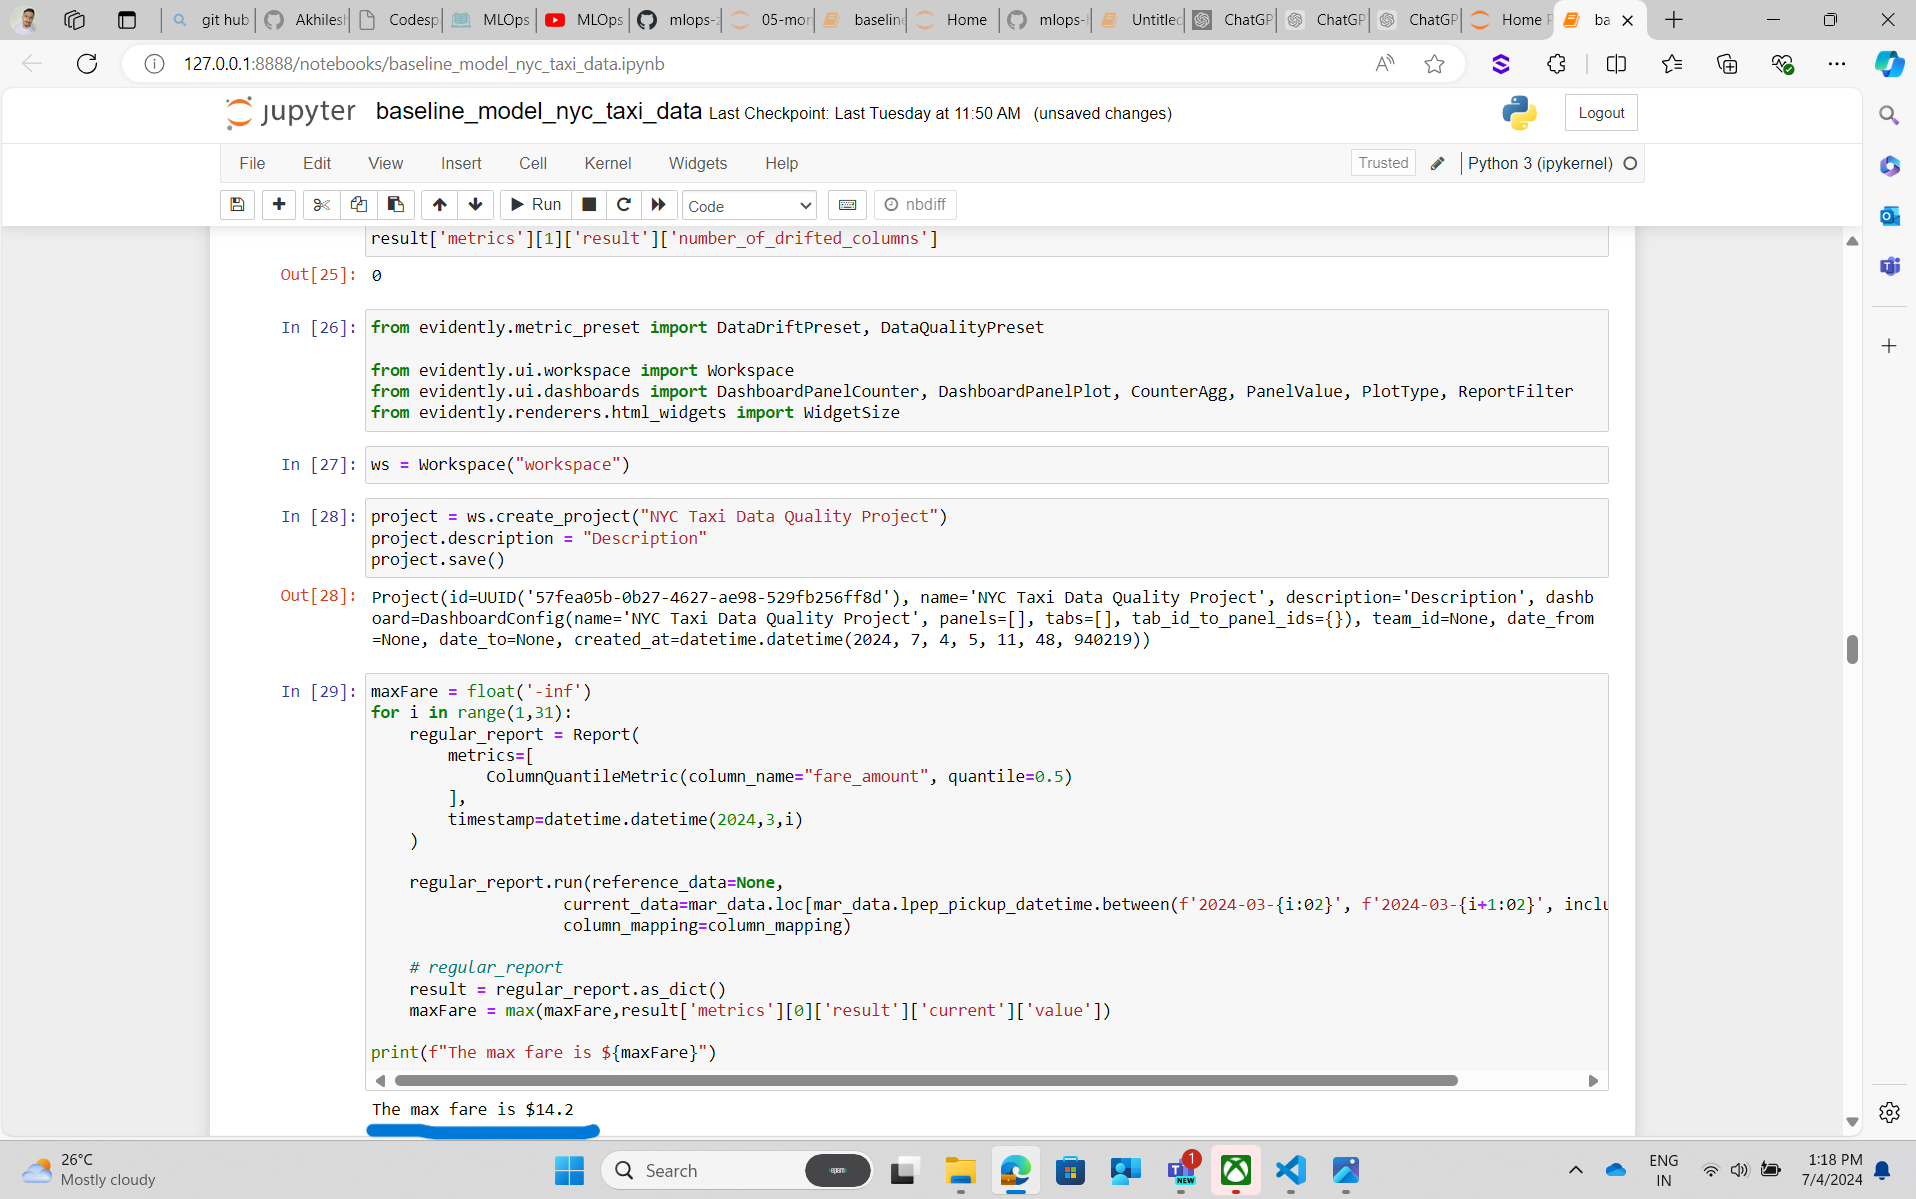

Answer: 14.2

In [30]:
regular_report = Report(
    metrics=[
        DataQualityPreset(),
        ColumnQuantileMetric(column_name="fare_amount", quantile=0.5),
        RegressionQualityMetric()
    ]
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2024-03-01', '2024-03-31', inclusive="left")],
                  column_mapping=column_mapping)

regular_report

In [31]:
#Add report to the workspace
ws.add_report(project.id, regular_report)

Q4. Dashboard
Finally, let’s add panels with new added metrics to the dashboard. After we customize the dashboard let's save a dashboard config, so that we can access it later. Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

project_folder (05-monitoring)
project_folder/config (05-monitoring/config)
project_folder/dashboards (05-monitoring/dashboards)
project_folder/data (05-monitoring/data)

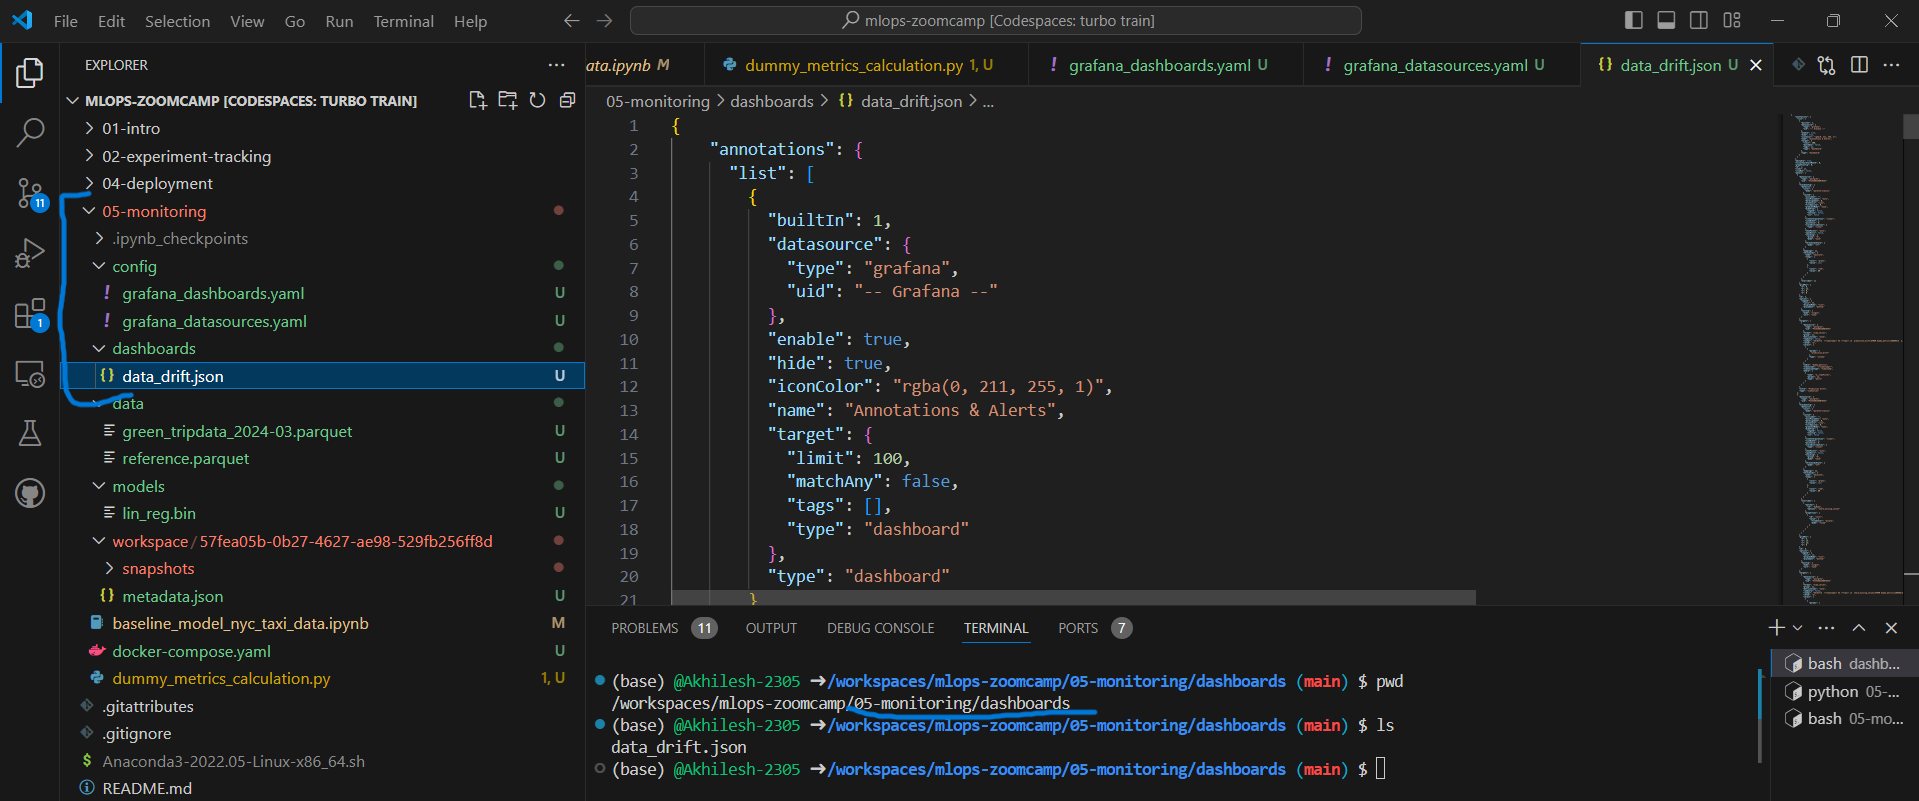

Answer: project_folder/dashboards (05-monitoring/dashboards)